In [37]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import os

from jamie import JAMIE
from jamie.evaluation import *
from jamie.utilities import *
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

In [39]:
np.random.seed(42)
model_folder = './saved_models/'
image_folder = './output_figures/tuning/'
output_folder = './output_data/'

In [40]:
dataset_name = 'scMNC-Visual'
dataset_color = 'magenta'
modality_names = ['Gene Expression', 'Electrophysiology']
data_folder = '../data/scMNC/mouse_visual_cortex/data/'
data1 = pd.read_csv(data_folder + "geneExp_filtered.csv")
data2 = pd.read_csv(data_folder + "efeature_filtered.csv")
sample_names1 = data1.columns[1:]
sample_names2 = np.array(data2)[:, 0]
feature_names1 = data1.iloc[:,0]
feature_names2 = data2.columns[3:]
assert (sample_names1 == sample_names2).all()
data1 = np.transpose(np.array(data1)[:, 1:])
data2 = np.array(data2)[:, 3:]
meta = pd.read_csv(data_folder + "20200711_patchseq_metadata_mouse.csv")
meta_names = np.array(meta.columns)
meta_sid = np.argwhere(meta_names == 'transcriptomics_sample_id')[0][0]
meta_ttype = np.argwhere(meta_names == 't_type')[0][0]
meta = np.array(meta)
meta_idx = [np.argwhere(meta[:, meta_sid] == sample_names1[i])[0][0] for i in range(sample_names1.shape[0])]
type1 = type2 = np.array([x.split(' ')[0] for x in meta[meta_idx, meta_ttype]])

# Sampling
# split = 1000 # data1.shape[0]
# data_col_idx = np.random.choice(range(data1.shape[0]), split, replace=False)
# data1, data2, type1, type2 = (x[data_col_idx] for x in (data1, data2, type1, type2))

# Labels
labels = [type1, type2]
features = [np.array(feature_names1), np.array(feature_names2)]
feature_dict = {}

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

In [41]:
# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
# data1 = preprocessing.MinMaxScaler().fit_transform(data1)
# data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = np.array([f'Feature {i}' for i in range(dataset[i].shape[1])])
        
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size, replace=False)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

# Reduced Priors
full_priors = np.eye(len(dataset[0]))
random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)
random_idx = np.random.choice(range(len(dataset[0])), int(.75 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
tq_priors = np.diag(priors)
none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

In [42]:
reduced_dim = 32
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 10000,
    'min_epochs': 2500,
    'log_DNN': 500,
    'use_early_stop': True,
    'batch_size': 512,
    'pca_dim': 2*[512],
    'dist_method': 'euclidean',
    'loss_weights': [1,1,1,1],
    'dropout': 0,
}
kwargs_imp = {k: kwargs[k] for k in kwargs if k != 'dropout'}

In [43]:
integrated_data = []
integrated_names = []
colors = []
shapes = []

# JAMIE

In [44]:
# Integration
size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
prefix = model_folder + 'jm---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm = JAMIE(**kwargs, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_data = jm.fit_transform(dataset=dataset)
    jm.save_model(model_str)
    np.save(match_str, jm.match_result, allow_pickle=True)
jm_data = jm.transform(dataset=dataset)
integrated_data.append(jm_data)
integrated_names.append('JAMIE')
colors.append('blue')
shapes.append('8')

Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0.h5'


In [45]:
def run_jamie(kwargs, dataset, idx=None, prior=None, hashName='jm---'):
    size_str, hash_str = hash_kwargs(kwargs, dataset_name, dataset)
    prefix = model_folder + hashName
    model_str = prefix + hash_str + '.h5'
    match_str = prefix + size_str + '.npy'

    # Instantiate
    mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
    jm = JAMIE(**kwargs, match_result=mr, debug=True)

    # Train
    if os.path.exists(model_str):
        jm.load_model(model_str)
        print(f'Loaded model \'{model_str}\'')
    else:
        jm_data = jm.fit_transform(dataset=dataset if idx is None else [d[idx] for d in dataset], P=prior)
        jm.save_model(model_str)
        np.save(match_str, jm.match_result, allow_pickle=True)
    jm_data = jm.transform(dataset=dataset)
    
    return jm, jm_data

for name, lw, cl in zip(
    ('$\\gamma=0$', '$\\beta=0$', '$\\alpha=0$', '$\\kappa=0$'),
    ([1,1,1,0],[1,1,0,1],[1,0,1,1],[0,1,1,1]),
    ('pink', 'orange', 'green', 'red'),):
    print(f'{name}: {lw}')
    # result = run_jamie({k: kwargs[k] if k != 'loss_weights' else lw for k in kwargs}, half_priors, 'jm_50---')
    result = run_jamie({k: kwargs[k] if k != 'loss_weights' else lw for k in kwargs}, dataset)
    integrated_data.append(result[1])
    integrated_names.append(f'JAMIE ({name})')
    colors.append(cl)
    shapes.append('o')
    print()

$\gamma=0$: [1, 1, 1, 0]
Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0--loss_weights-(1-1-1-0).h5'

$\beta=0$: [1, 1, 0, 1]
Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0--loss_weights-(1-1-0-1).h5'

$\alpha=0$: [1, 0, 1, 1]
Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0--loss_weights-(1-0-1-1).h5'

$\kappa=0$: [0, 1, 1, 1]
Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0--loss_weights-(0-1-1-1).h5'



In [46]:
result = run_jamie({k: kwargs[k] if k != 'pca_dim' else 2*[128] for k in kwargs}, dataset)
integrated_data.append(result[1])
integrated_names.append('JAMIE ($\\# PC=128$)')
colors.append('yellow')
shapes.append('s')

result = run_jamie({k: kwargs[k] if k != 'pca_dim' else 2*[32] for k in kwargs}, dataset)
integrated_data.append(result[1])
integrated_names.append('JAMIE ($\\# PC=32$)')
colors.append('purple')
shapes.append('s')

result = run_jamie({k: kwargs[k] if k != 'output_dim' else 16 for k in kwargs}, dataset)
integrated_data.append(result[1])
integrated_names.append('JAMIE ($g=16$)')
colors.append('teal')
shapes.append('*')

result = run_jamie({k: kwargs[k] if k != 'output_dim' else 8 for k in kwargs}, dataset)
integrated_data.append(result[1])
integrated_names.append('JAMIE ($g=8$)')
colors.append('lime')
shapes.append('*')

Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0--pca_dim-(128-128).h5'
Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0--pca_dim-(32-32).h5'
Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0--output_dim-16.h5'
Loaded model './saved_models/jm---scMNC-Visual---3654-1302---3654-39---dropout-0--output_dim-8.h5'


In [47]:
# Imputation
size_str, hash_str = hash_kwargs(kwargs_imp, dataset_name, dataset)
prefix = model_folder + 'jm_im---'
model_str = prefix + hash_str + '.h5'
match_str = prefix + size_str + '.npy'

# Instantiate
mr = list(np.load(match_str, allow_pickle=True)) if os.path.exists(match_str) else None
jm_im = JAMIE(**kwargs_imp, match_result=mr, debug=True)

# Train
if os.path.exists(model_str):
    jm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
else:
    jm_im.fit_transform(dataset=[d[train_idx] for d in dataset])
    jm_im.save_model(model_str)
    np.save(match_str, jm_im.match_result, allow_pickle=True)
jm_imputed = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

Loaded model './saved_models/jm_im---scMNC-Visual---3654-1302---3654-39.h5'


In [48]:
# Imputation
jm_im, _ = run_jamie({k: kwargs_imp[k] if k != 'loss_weights' else [0, 1, 1, 1] for k in kwargs_imp}, dataset, idx=train_idx, hashName='jm_im---')
jm_imputed_nok = [jm_im.modal_predict(dataset[i], i) for i in range(1, -1, -1)]

Loaded model './saved_models/jm_im---scMNC-Visual---3654-1302---3654-39---loss_weights-(0-1-1-1).h5'


# Comparison Methods

In [49]:
imputed_data_full = [jm_imputed_nok, jm_imputed]
imputed_data = [[d[test_idx] for d in ds] for ds in imputed_data_full]
imputed_names = ['JAMIE ($\\kappa=0$)', 'JAMIE']

# Visualization

In [50]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

In [51]:
%%capture
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

algorithm_elements = [Line2D([0], [0], marker='s', color='w', markerfacecolor=c, label=n, markersize=10) for n, c in zip(integrated_names, colors)]
label_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label=l, markersize=10) for i, l in enumerate(np.unique(labels))]

# https://stackoverflow.com/a/47749903
fig, ax = plt.subplots()
legend = ax.legend(handles=label_elements, loc='center', frameon=False, ncol=min(len(label_elements), 4))
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-LabelLegend.png', bbox_inches=bbox, dpi=300)

fig, ax = plt.subplots()
legend = ax.legend(handles=algorithm_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.axis('off')
plt.savefig(image_folder + dataset_name + '-AlgorithmLegend.png', bbox_inches=bbox, dpi=300)

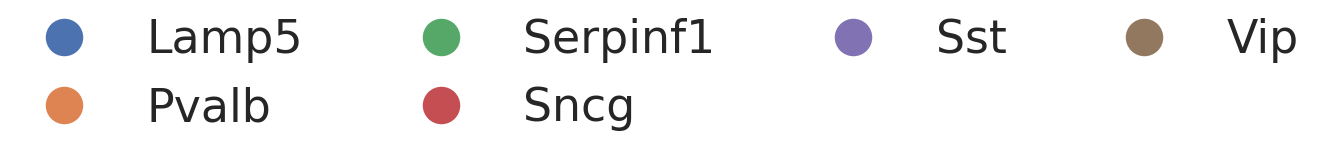

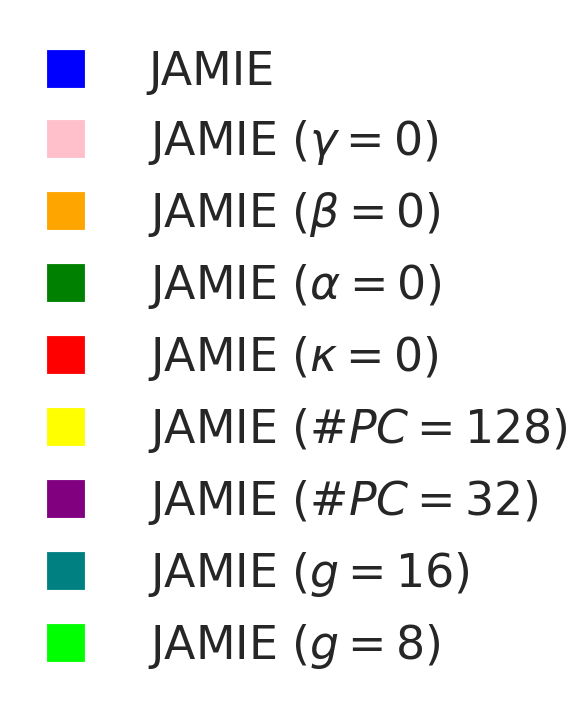

In [52]:
from IPython.display import display, Image
display( Image(filename=image_folder + dataset_name + '-LabelLegend.png', width=400) )
display( Image(filename=image_folder + dataset_name + '-AlgorithmLegend.png', width=100) )

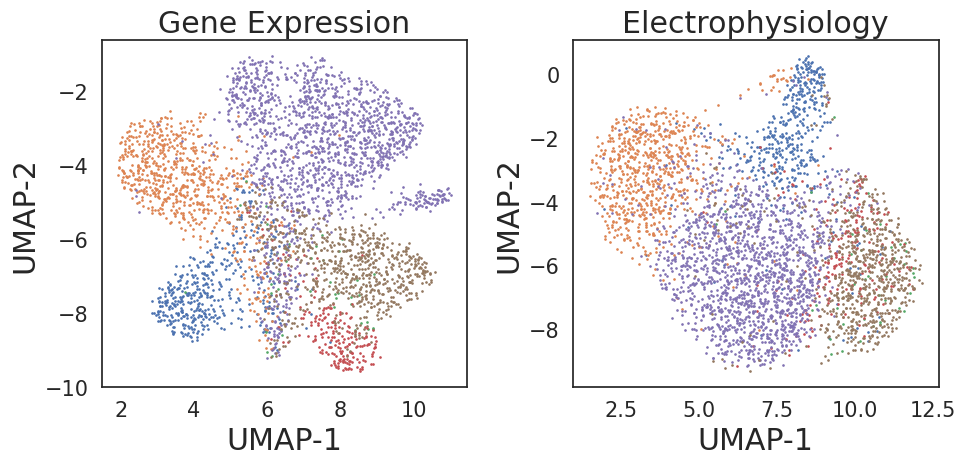

In [17]:
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Data.png', dpi=300, bbox_inches='tight')

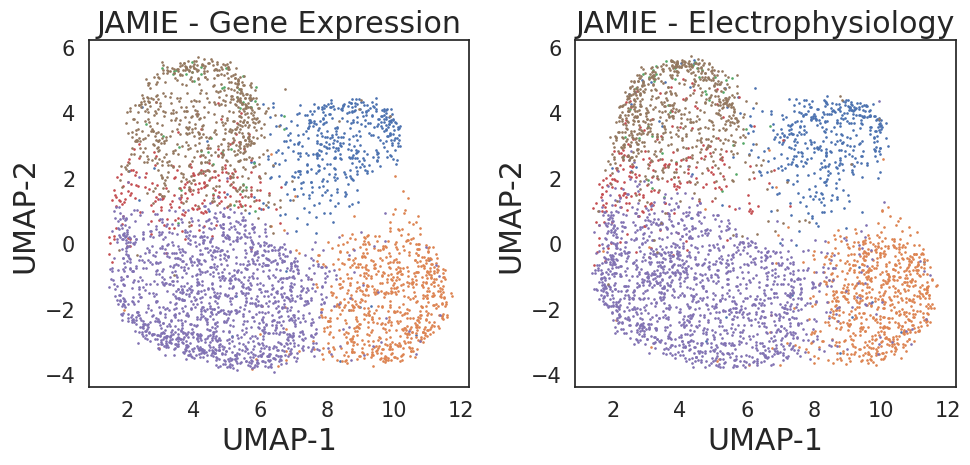

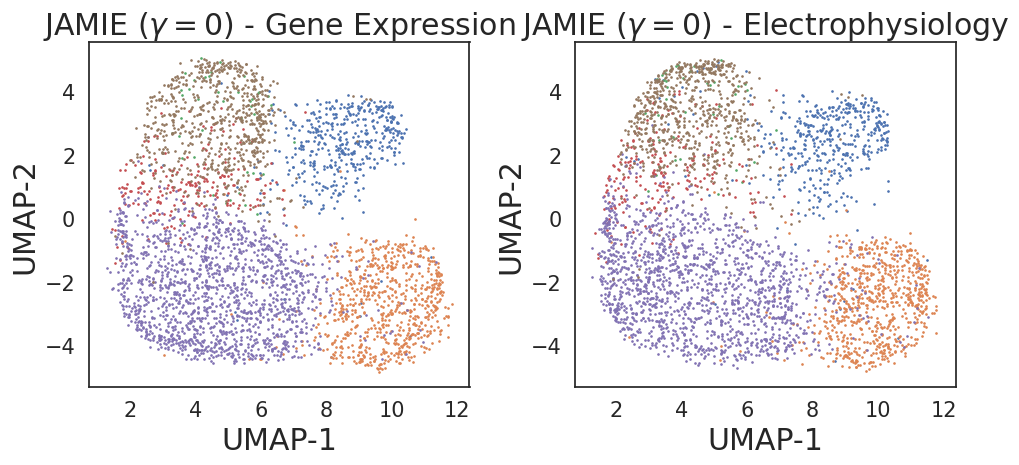

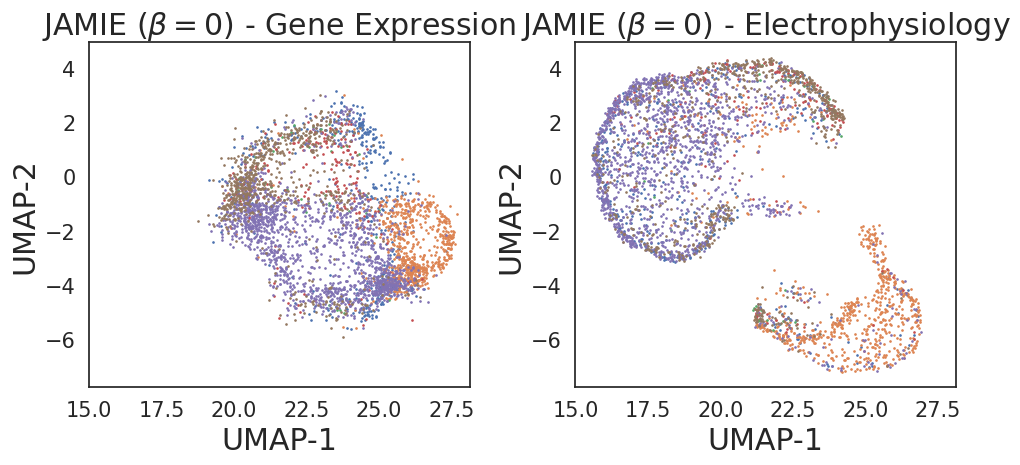

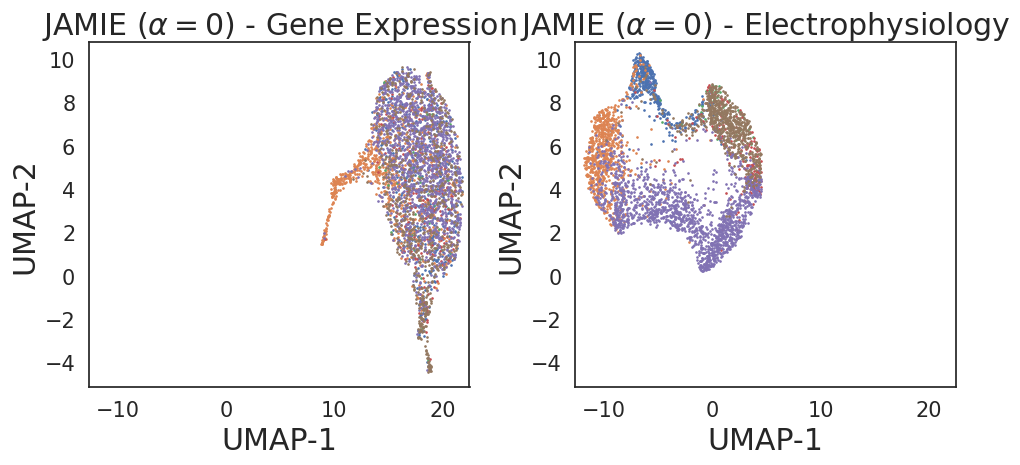

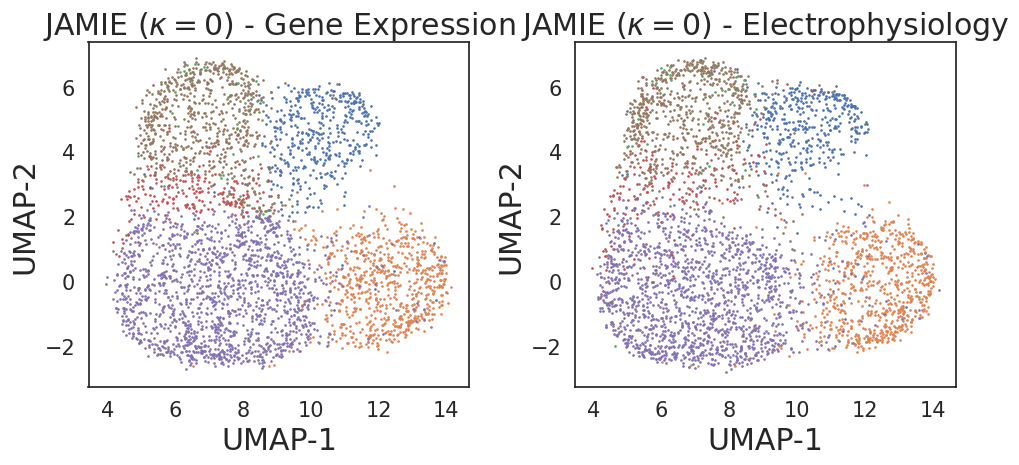

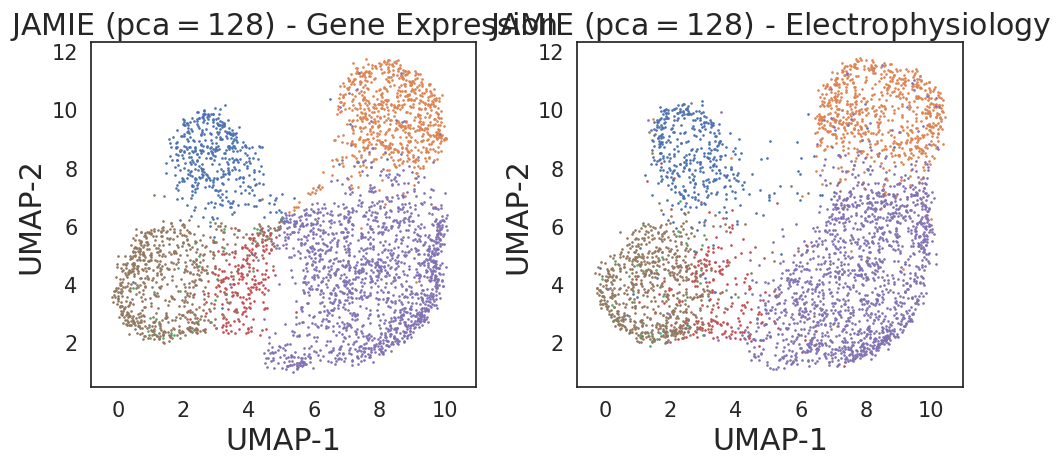

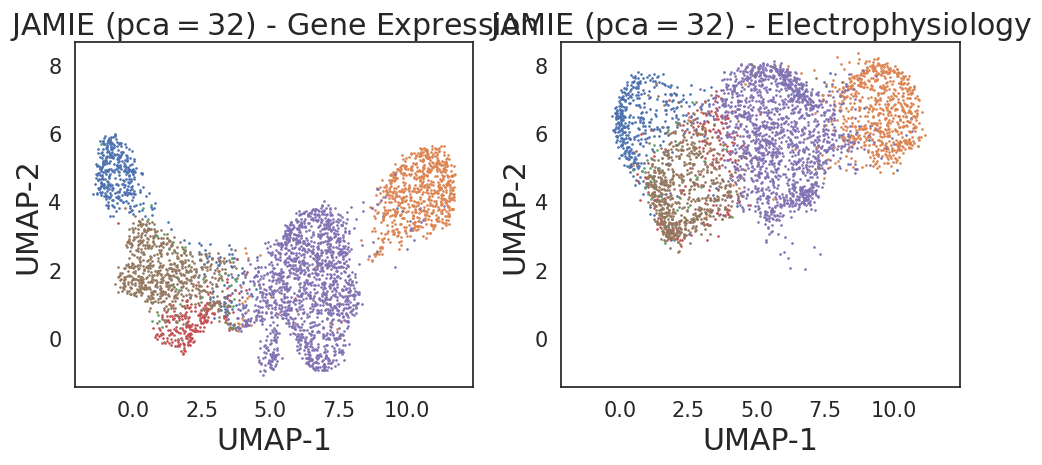

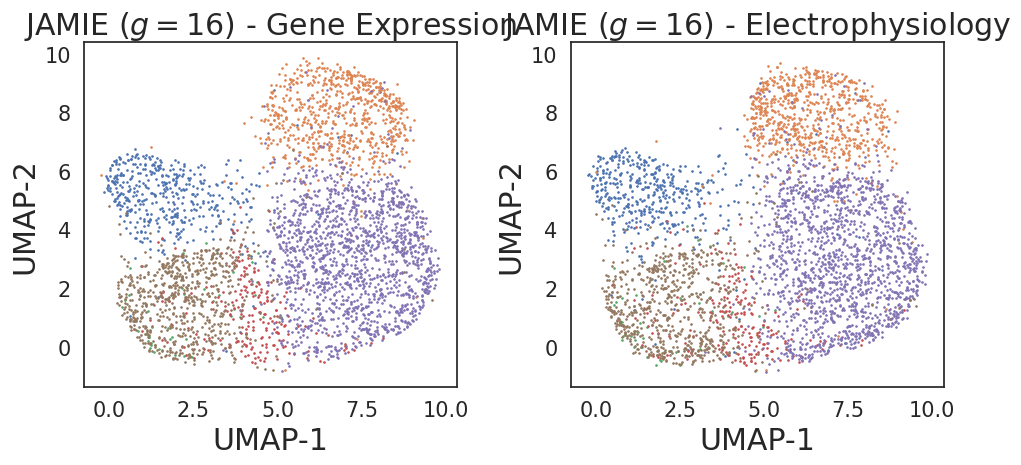

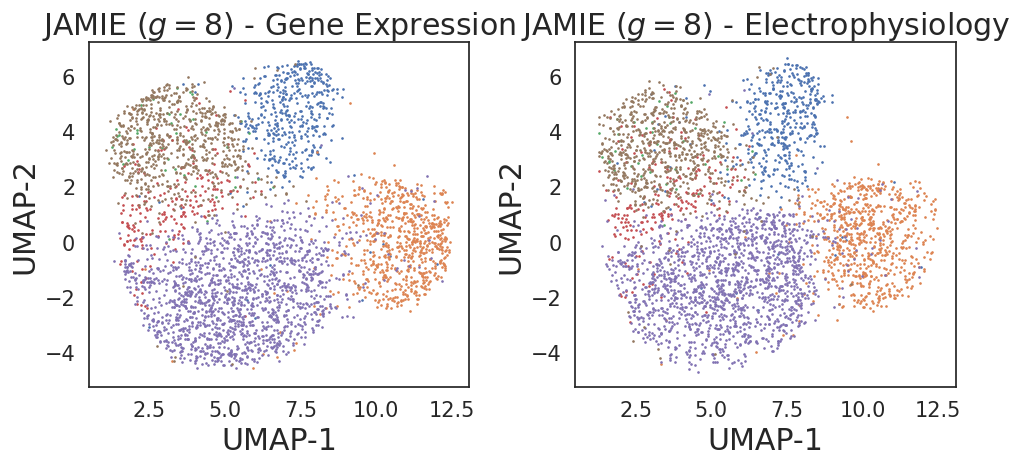

In [18]:
for d, n in zip(integrated_data, integrated_names):
    fig = plt.figure(figsize=(10, 5))
    plot_integrated(d, labels, [f'{n} - ' + mn for mn in modality_names])
    plt.tight_layout()
    plt.savefig(image_folder + dataset_name + f'-{n}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [17]:
weight_idx = [0, 1, 2, 3, 4]
pca_idx = [0, 5, 6]
dim_idx = [0, 7, 8]

Algorithm     JAMIE  JAMIE ($\gamma=0$)  JAMIE ($\beta=0$)  \
LTA        0.946360            0.939518           0.352490   
FOSCTTM    0.002149            0.001508           0.477158   

Algorithm  JAMIE ($\alpha=0$)  JAMIE ($\kappa=0$)  
LTA                  0.423372            0.949644  
FOSCTTM              0.496604            0.006677  


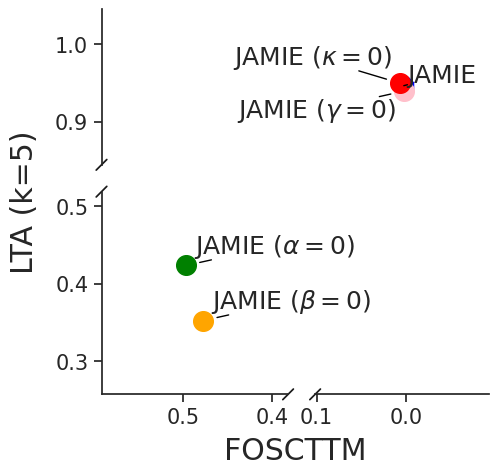

In [53]:
plt.figure(figsize=(5, 5))
idx = weight_idx
plot_accuracy_graph([integrated_data[i] for i in idx], labels, [integrated_names[i] for i in idx], colors=[colors[i] for i in idx], shapes=[shapes[i] for i in idx])
plt.savefig(image_folder + dataset_name + '-AccWeight.png', dpi=300, bbox_inches='tight')

Algorithm  JAMIE ($\# PC=512$)  JAMIE ($\# PC=128$)  JAMIE ($\# PC=32$)
LTA                   0.946360             0.949371            0.874111
FOSCTTM               0.002149             0.020308            0.236881


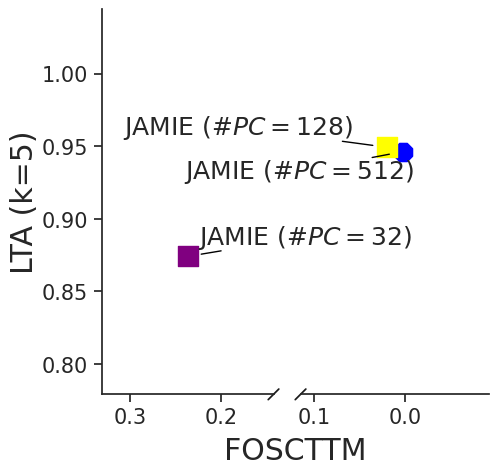

In [54]:
plt.figure(figsize=(5, 5))
idx = pca_idx
plot_accuracy_graph([integrated_data[i] for i in idx], labels, [integrated_names[i] if i != 0 else 'JAMIE ($\\# PC=512$)' for i in idx], colors=[colors[i] for i in idx], shapes=[shapes[i] for i in idx])
plt.savefig(image_folder + dataset_name + '-AccPCA.png', dpi=300, bbox_inches='tight')

Algorithm  JAMIE ($g=32$)  JAMIE ($g=16$)  JAMIE ($g=8$)
LTA              0.946360        0.942802       0.936782
FOSCTTM          0.002149        0.001177       0.004261


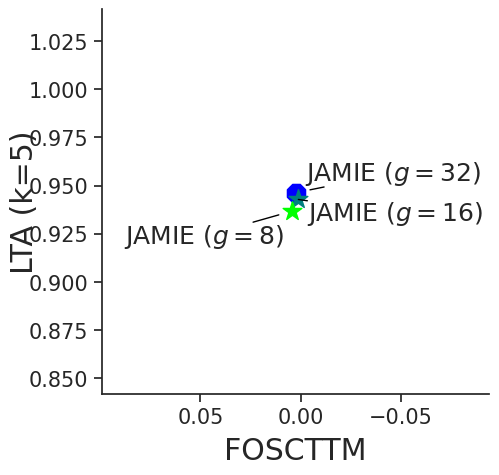

In [55]:
plt.figure(figsize=(5, 5))
idx = dim_idx
plot_accuracy_graph([integrated_data[i] for i in idx], labels, [integrated_names[i] if i != 0 else 'JAMIE ($g=32$)' for i in idx], colors=[colors[i] for i in idx], shapes=[shapes[i] for i in idx])
plt.savefig(image_folder + dataset_name + '-AccDim.png', dpi=300, bbox_inches='tight')

In [24]:
# plt.figure(figsize=(15, 5))
# plot_silhouette([[d[0]] for d in integrated_data], [labels[0]], integrated_names, modality_names[:1], colors=colors)
# sns.despine()
# plt.tight_layout()
# plt.savefig(image_folder + dataset_name + '-Sil.png', dpi=300, bbox_inches='tight')

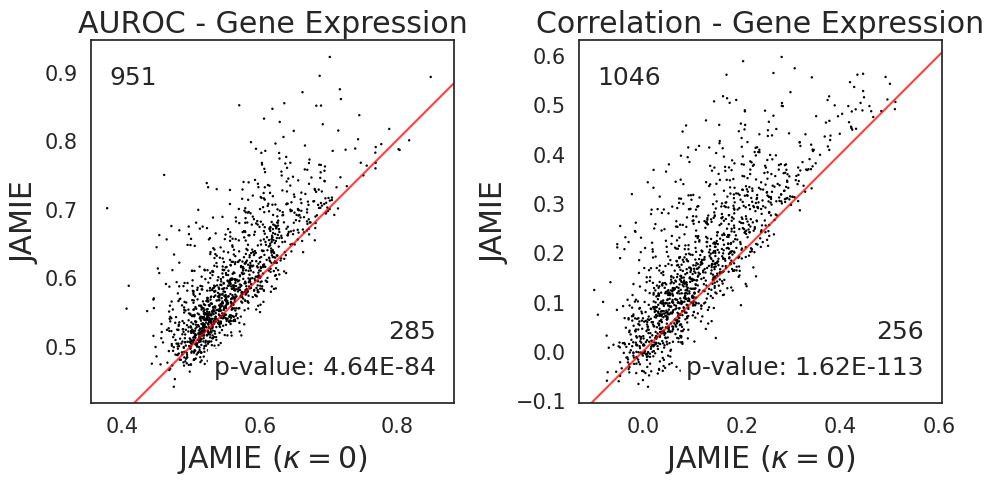

In [25]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp1.png', dpi=300, bbox_inches='tight')

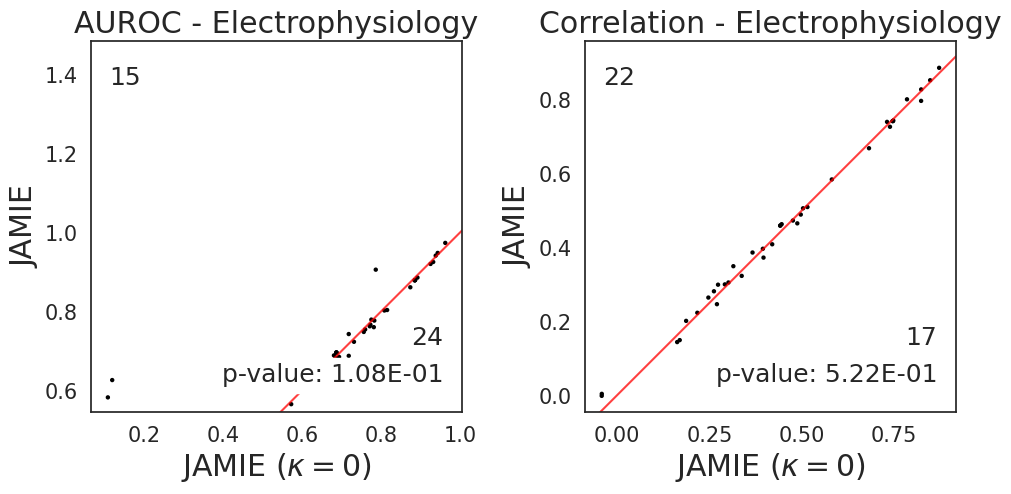

In [26]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Imp2.png', dpi=300, bbox_inches='tight')

Kcnc1: 0.39276709840912855
Kcnc2: 0.44766526920564464


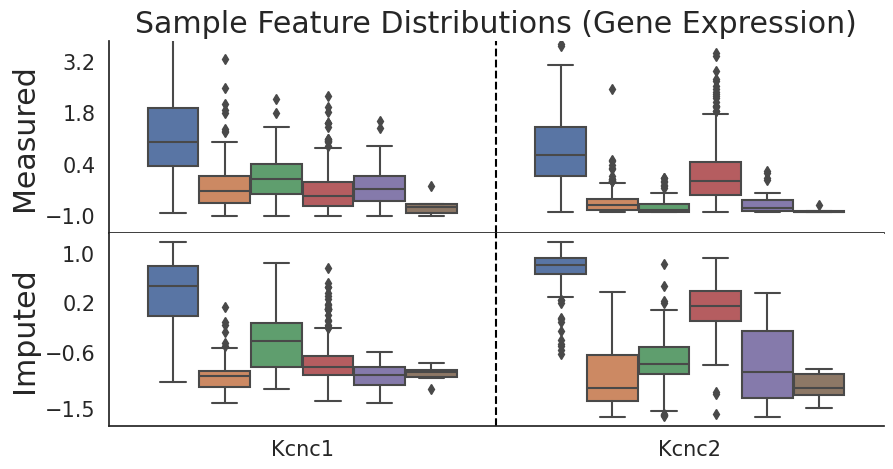

In [27]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]], feature_dict=feature_dict)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist1.png', dpi=300, bbox_inches='tight')

threshold_i_ramp: 0.27996704492923064
threshold_t_ramp: 0.28192286414583995


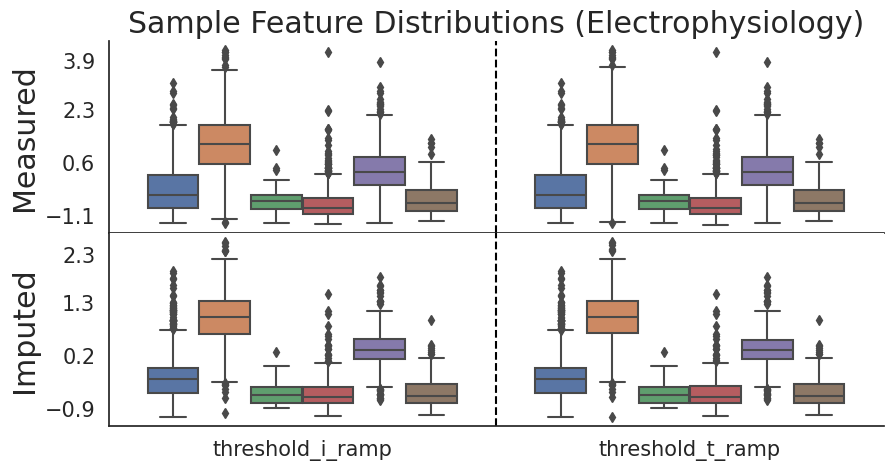

In [28]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1], jm_imputed[1]], 2*[labels[1]], title=modality_names[1], fnames=2*[features[1]], feature_dict=feature_dict, remove_outliers=False)
sns.despine()
plt.savefig(image_folder + dataset_name + '-Dist2.png', dpi=300, bbox_inches='tight')

Mean: 0.5927240136221608
Std: 0.11702043844294903


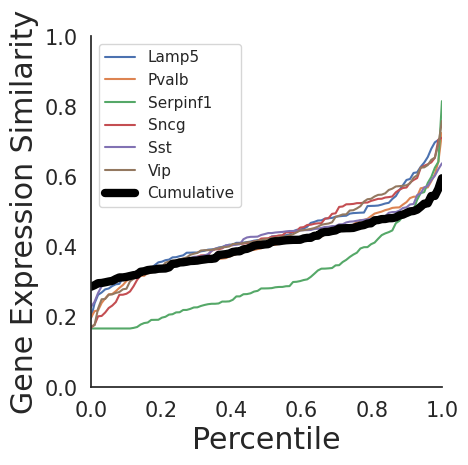

In [29]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[0][test_idx], jm_imputed[0][test_idx]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Sim1.png', dpi=300, bbox_inches='tight')

Mean: 0.5367399942360072
Std: 0.11453061954732813


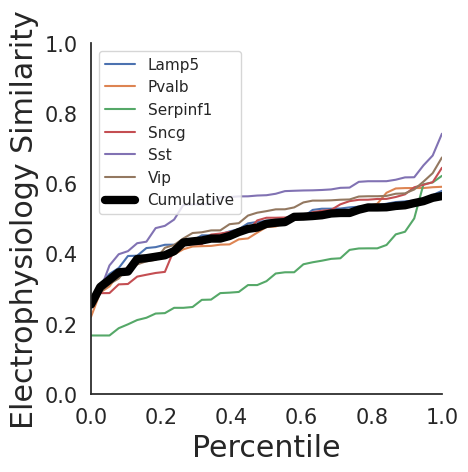

In [30]:
plt.figure(figsize=(5, 5))
plot_distribution_similarity([dataset[1][test_idx], jm_imputed[1][test_idx]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.tight_layout()
plt.savefig(image_folder + dataset_name + '-Sim2.png', dpi=300, bbox_inches='tight')